In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../")))
sys.path[0] = ROOT_PROJECT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
ipython_format = "retina"
if isinstance(ipython_format, str):
    ipython_format = [ipython_format]
matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)

# plt.style.use('seaborn-whitegrid') 
import scienceplots
plt.style.use(['science','no-latex'])
plt.rcParams['figure.figsize'] = (12.0, 7.0)


from mcbo.utils.experiment_utils import get_bo_short_opt_id, get_opt_results
from mcbo.utils.general_plot_utils import plot_task_regrets, plot_curves_with_ranked_legends, COLORS, MARKERS

In [2]:
class Experiment:
    def __init__(self, task_kwargs, models, seeds, budget_eval, selected_opt):
        self.tasks = {
            "rna_inverse_fold": "RNA Inverse Folding",
            "ackley": "Ackley Function",
            "pest": "Pest Control",
            "mig_optimization": "MIG Sequence Optimisation - sqrt - both",
            "antibody_design": "2DD8_S Antibody Design",
            "aig_optimization": "EDA Sequence Optimization - Design sin - Ops basic - Pattern basic - Obj both",
        }
        self.beautiful_tasks = {
            "rna_inverse_fold": "RNA Inverse Folding",
            "ackley": "Ackley Function",
            "pest": "Pest Control",
            "antibody_design": "Antibody Design",
            "aig_optimization": "AIG Flow Tuning",
            "mig_optimization": "MIG Flow Tuning",
        }
        self.task_kwargs = task_kwargs
        self.models = models
        self.seeds = seeds
        self.budget_eval = budget_eval
        self.selected_opt = selected_opt
        
    def _get_ours_data(self, task_id):
        results_list = []
        for model in self.models:
            variant = model.pop("variant")
            opt_short_name = get_bo_short_opt_id(**model)
            results = get_opt_results(
                task_id=task_id, 
                opt_short_name=opt_short_name,
                seeds=self.seeds,
                variant=variant,
                **self.task_kwargs
            )
            model["variant"] = variant
            results_list.append(results)
        results = pd.concat(results_list, ignore_index=True, sort=False)
        return results

    def _get_baseline_data(self, task_id):
        task = self.tasks[task_id]
        lib_data = pd.read_csv("paper_results/data_mcbo/all_res_comb.csv", index_col=0)
        lib_data = lib_data[lib_data.Optimizer.isin(self.selected_opt)]
        lib_data = lib_data[lib_data.Seed.isin(self.seeds)]
        lib_data = lib_data[lib_data.Task == task]
        return lib_data

    def _prep_and_merge(self, task_id):
        # load + merge data
        results = self._get_ours_data(task_id)
        lib_data = self._get_baseline_data(task_id)
        all_res = pd.concat([lib_data, results], ignore_index=True)
        all_res = all_res[all_res["Eval Num"] <= self.budget_eval]

        # prep data
        data_y = {}
        for opt, opt_group in all_res.groupby("Optimizer"):
            if opt in self.selected_opt:
                k = f" (Baseline) {opt}"
            else:
                k = f" (Ours) {opt}"
            data_y[k] = np.stack([g["f(x*)"].values for s, g in opt_group.groupby("Seed")])

        return data_y
        
    def plot(self, task_id):
        data_y = self._prep_and_merge(task_id)
        fig, ax = plt.subplots(figsize=(12, 5))
        plot_curves_with_ranked_legends(ax=ax, data_y=data_y, data_x=np.arange(1, 1 + self.budget_eval), zoom_end_pct=0.7)
        ax.set_title(f"{self.tasks[task_id]}", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_xlabel("Number of iterations", fontsize=22)
        plt.tight_layout()
        plt.show()        

    def _data_key_to_label(self, k: str):
        k = k.replace("LR (sparse_horseshoe)", "LSH")
        k = k.replace("HED-mat52", "HED")
        k = k.replace("Diffusion", "Diff.")
        k = k.replace("basic", "w/ TR")
        k = k.replace("no-tr", "w/o TR")
        k = k.replace("Tr-based GA acq optim", "GA w/ TR")
        k = k.replace("IS acq optim", "HC acq optim")
        return k
    
    def plot_all(self):

        data_color = None
        data_marker = None

        # Grid of subplots when we know n_col and the number of elements to plot
        n_el = len(self.tasks)

        n_col = 3 + 1
        n_row = np.ceil(n_el / n_col).astype(int)

        fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, 3 * n_row), width_ratios=[3 for _ in range(n_col - 1)] + [1], sharex=True)
        legend_ax_aux = axes[0, -1].get_gridspec()
        # remove the underlying axes
        for ax in axes[:, -1]:
            ax.remove()
            
        legend_ax = fig.add_subplot(legend_ax_aux[:, -1])

        ind = 0
        for task_id in self.tasks.keys():
            i_row = ind // (n_col - 1)
            j_col = ind % (n_col - 1)
            ax = axes[i_row, j_col]
            
            data_y = self._prep_and_merge(task_id)
            if data_color == None and data_marker == None:
                data_color = {data_key: COLORS[i % len(COLORS)] for i, data_key in enumerate(data_y)}
                data_marker = {data_key: MARKERS[i % len(MARKERS)] for i, data_key in enumerate(data_y)}

            ax = plot_task_regrets(ax=ax, data_x=np.arange(1, 1 + self.budget_eval), data_y=data_y, ci_level=0.95, show_std_error=False,
                                   zoom_end_pct=.7, data_color=data_color, data_marker=data_marker, data_key_to_label=self._data_key_to_label)

            ind += 1
            
            ax.set_title(self.beautiful_tasks[task_id], fontsize=20)
            ax.tick_params(axis='both', which='major', labelsize=16)
            if i_row == (n_row - 1):
                ax.set_xlabel("Number of iterations", fontsize=22)
            if j_col == 0:
                ax.set_ylabel("Best objective value", fontsize=20)
                
        handles, labels = ax.get_legend_handles_labels()

        legend_ax.set_axis_off()
        legend_ax.legend(handles, labels, fontsize=16, bbox_to_anchor=(-.4, .5), loc='center left', labelspacing=1.1)
            
        plt.tight_layout()    
        plt.savefig(f"./regret_all_comb_bests.pdf")
        plt.show()    

In [3]:
# SEED
seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

# TASK
task_kwargs = {}

# MODEL (OURS)
model1 = {
    "model_id": "gp_duv",
    "acq_func_id":  "ei",
    "acq_opt_id": "ga",
    "tr_id": "basic",
    "variant": 0,
}
model2 = {
    "model_id": "gp_duv",
    "acq_func_id":  "ei",
    "acq_opt_id": "ga",
    "tr_id": "basic",
    "variant": 3,
}
models = [model1, model2]
# models = [model2]

# MODEL (BASELINES)
selected_opt = ["Random Search", "GP (TO) - Tr-based GA acq optim"]
# selected_opt = ["Random Search", "GP (TO) - Tr-based GA acq optim", "GP (SSK) - Tr-based GA acq optim"]
# selected_opt = ["GP (TO) - Tr-based GA acq optim", "GP (Diffusion) - Tr-based GA acq optim"]

# BUDGET
budget_eval = 200

mig_optimization gp_duv__ga__ei__basic 42
mig_optimization gp_duv__ga__ei__basic 43
mig_optimization gp_duv__ga__ei__basic 44
mig_optimization gp_duv__ga__ei__basic 45
mig_optimization gp_duv__ga__ei__basic 46
mig_optimization gp_duv__ga__ei__basic 47
mig_optimization gp_duv__ga__ei__basic 48
mig_optimization gp_duv__ga__ei__basic 49
mig_optimization gp_duv__ga__ei__basic 50
mig_optimization gp_duv__ga__ei__basic 51
mig_optimization gp_duv__ga__ei__basic 42
mig_optimization gp_duv__ga__ei__basic 43
mig_optimization gp_duv__ga__ei__basic 44
mig_optimization gp_duv__ga__ei__basic 45
mig_optimization gp_duv__ga__ei__basic 46
mig_optimization gp_duv__ga__ei__basic 47
mig_optimization gp_duv__ga__ei__basic 48
mig_optimization gp_duv__ga__ei__basic 49
mig_optimization gp_duv__ga__ei__basic 50
mig_optimization gp_duv__ga__ei__basic 51
antibody_design gp_duv__ga__ei__basic 43
antibody_design gp_duv__ga__ei__basic 44
antibody_design gp_duv__ga__ei__basic 45
antibody_design gp_duv__ga__ei__basic

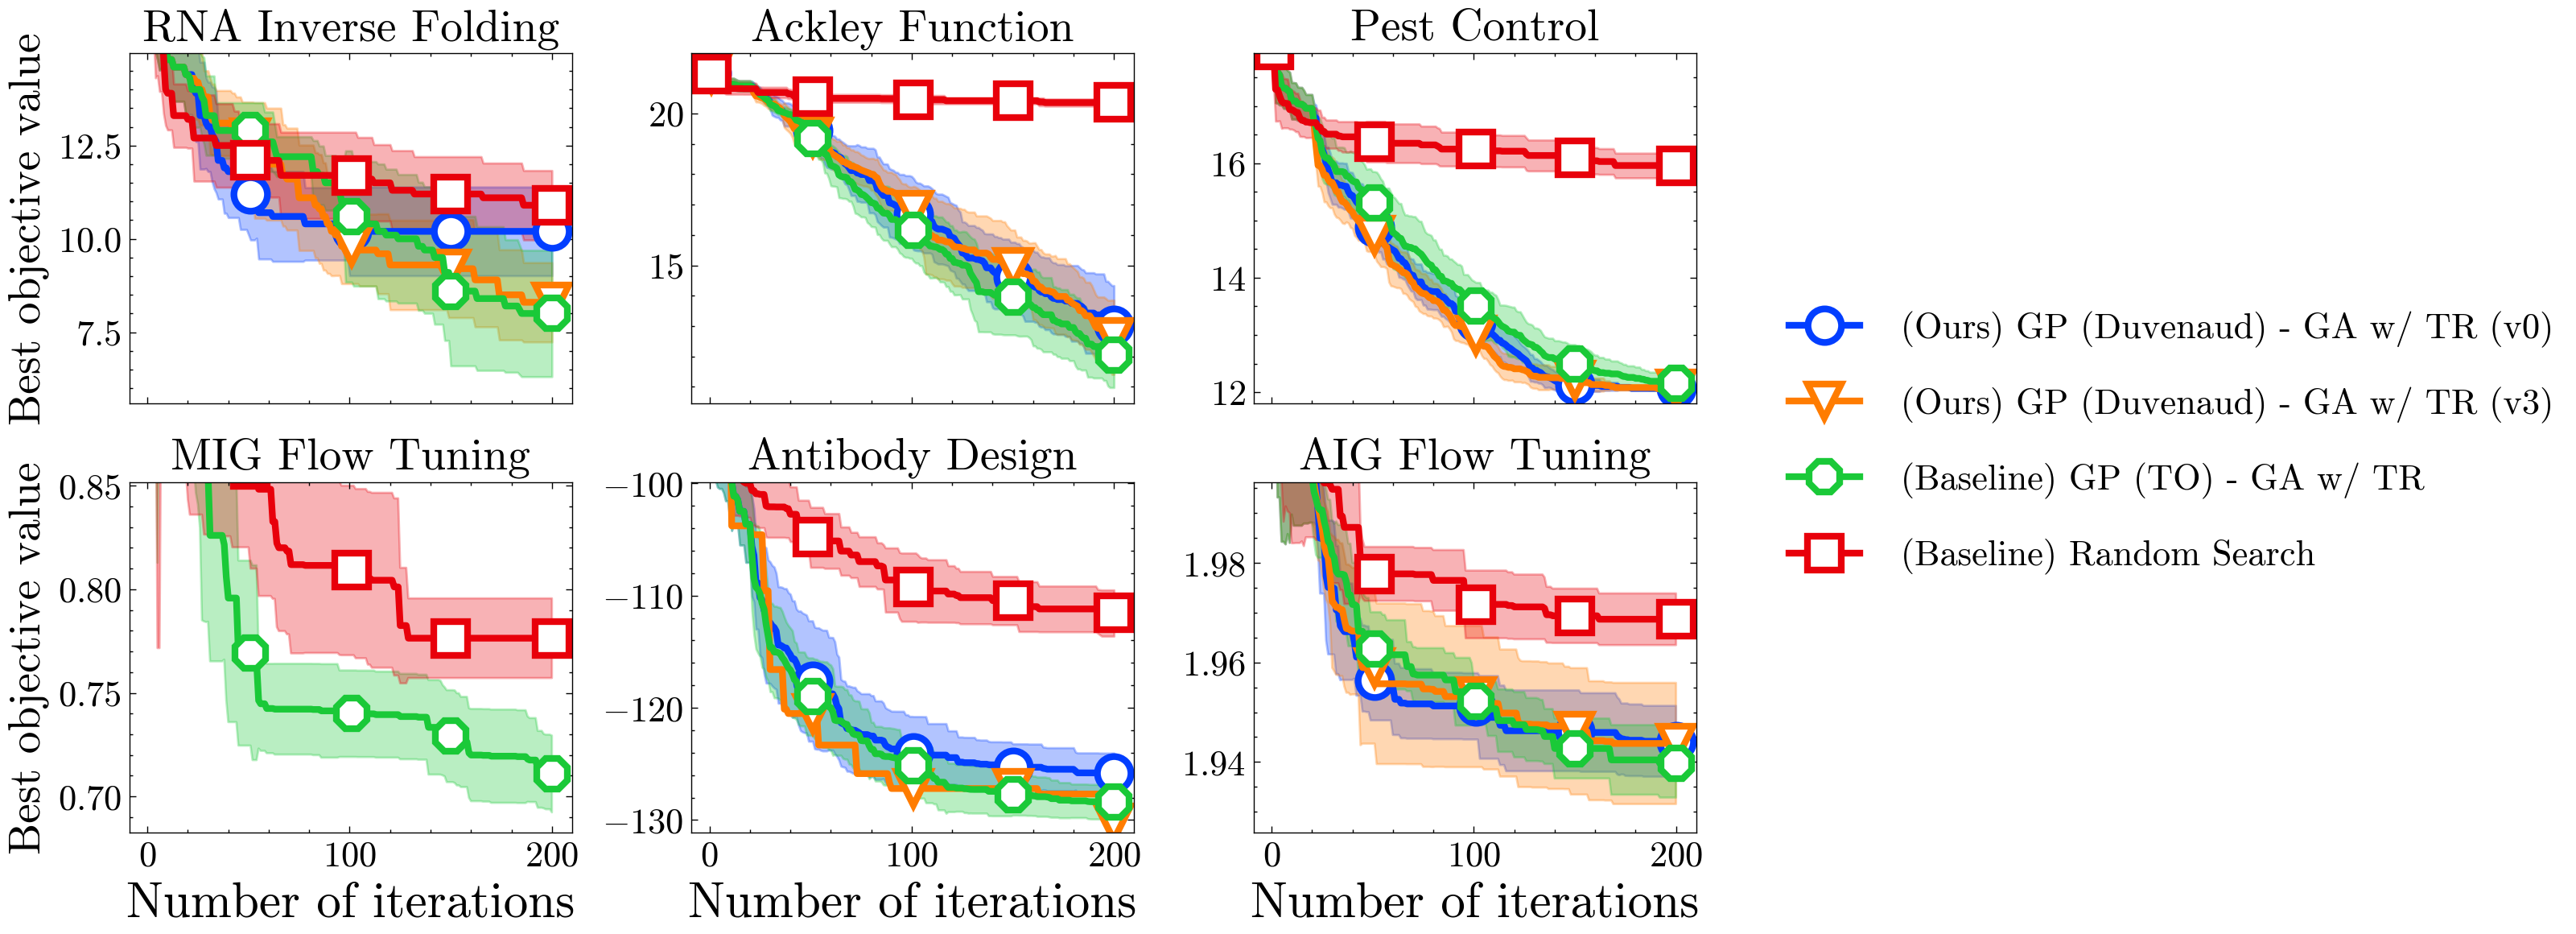

In [4]:
%matplotlib inline
experiment = Experiment(task_kwargs, models, seeds, budget_eval, selected_opt)
experiment.plot_all()